In [1]:
%matplotlib inline 
%load_ext memory_profiler

import pandas as pd
import numpy as np
import os
import sys
import glob
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [3]:
sc.settings.figdir = '/home/ngr4/project/scnd/results/'

In [4]:
def do_magic(X, goi=None, t=10):
    import magic 
    import graphtools as gt
    from scipy import sparse
    
    # compute PHATE
    G = gt.Graph(data=X.uns['neighbors']['connectivities']+sparse.diags([1]*X.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
    G.knn_max = None
    
    if goi is None:
        magic_op = magic.MAGIC(t=t).fit(X=X.X, graph=G)
        X.layers['imputed'] = magic_op.transform(X.X, genes='all')
        return X
    else:
        
        magic_op = magic.MAGIC(t=t).fit(X=X[:, goi].X, graph=G)
        Xprime = magic_op.transform(X[:, goi].X)
        return pd.DataFrame(Xprime, columns=goi, index=X.obs.index.to_list())

In [5]:
%%memit
adata_file = '/home/ngr4/project/scnd/data/processed/ubc.h5ad'
adata = sc.read(adata_file)
print(adata)

peak memory: 1055.54 MiB, increment: 862.21 MiB


In [8]:
goi = [
    'Eomes',
    'Slc17a6',
    'Trpc3',
    'Grm1',
    'Calb2',
    'Atxn1',
    'Gad1',
    'Slc6a5',
]

Xprime = do_magic(adata, goi=goi, t=3)
for i in Xprime.columns:
    adata.obs['{} (imputed)'.format(i)] = Xprime[i].values

<ipython-input-4-26056e9cf75c>:7: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  G = gt.Graph(data=X.uns['neighbors']['connectivities']+sparse.diags([1]*X.shape[0],format='csr'),


Running MAGIC on 3154 cells and 8 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...
Calculated imputation in 0.02 seconds.


/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


In [ ]:
# rename ubc subtype

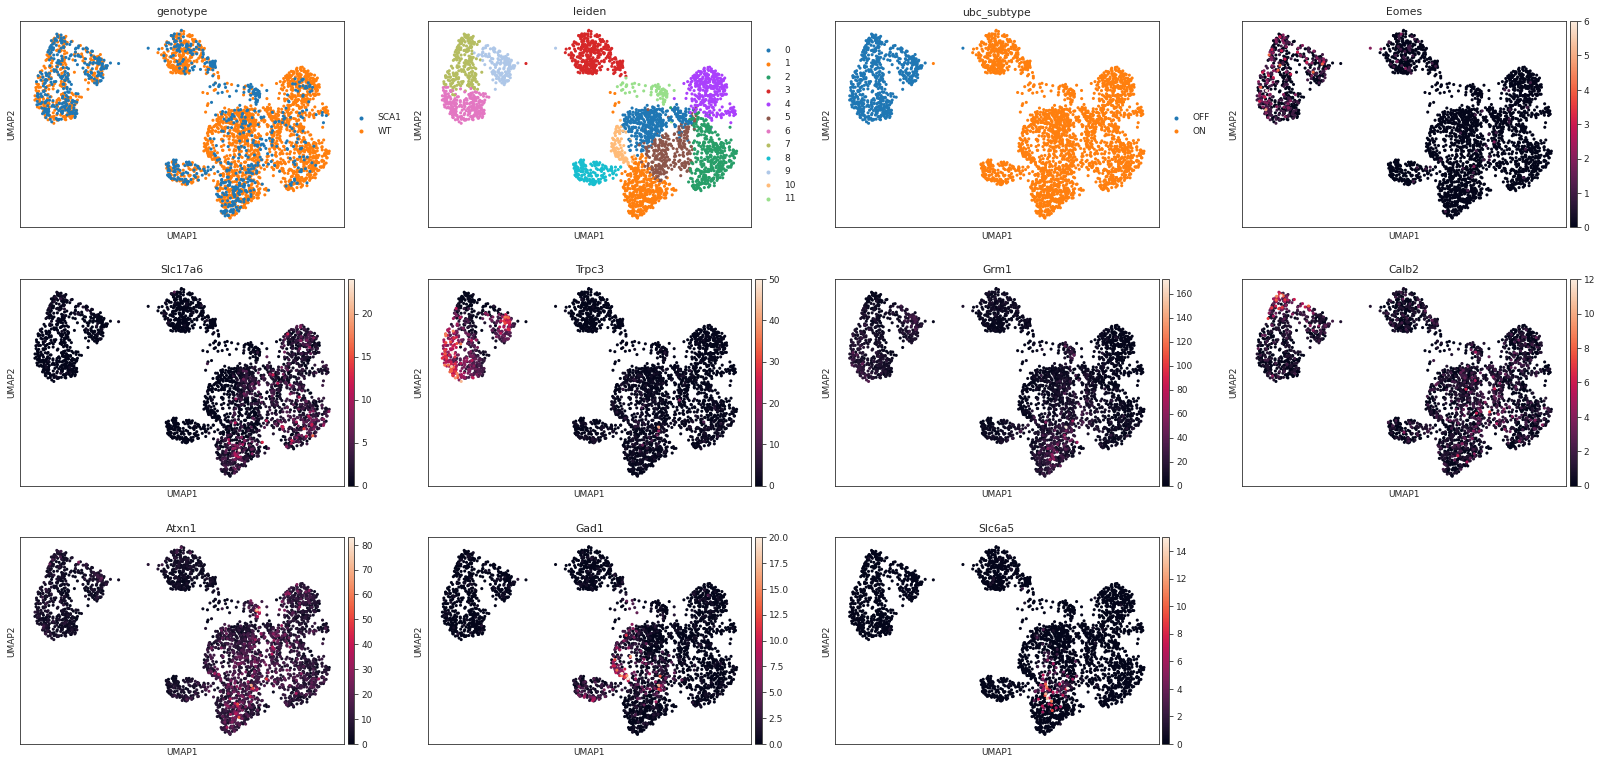

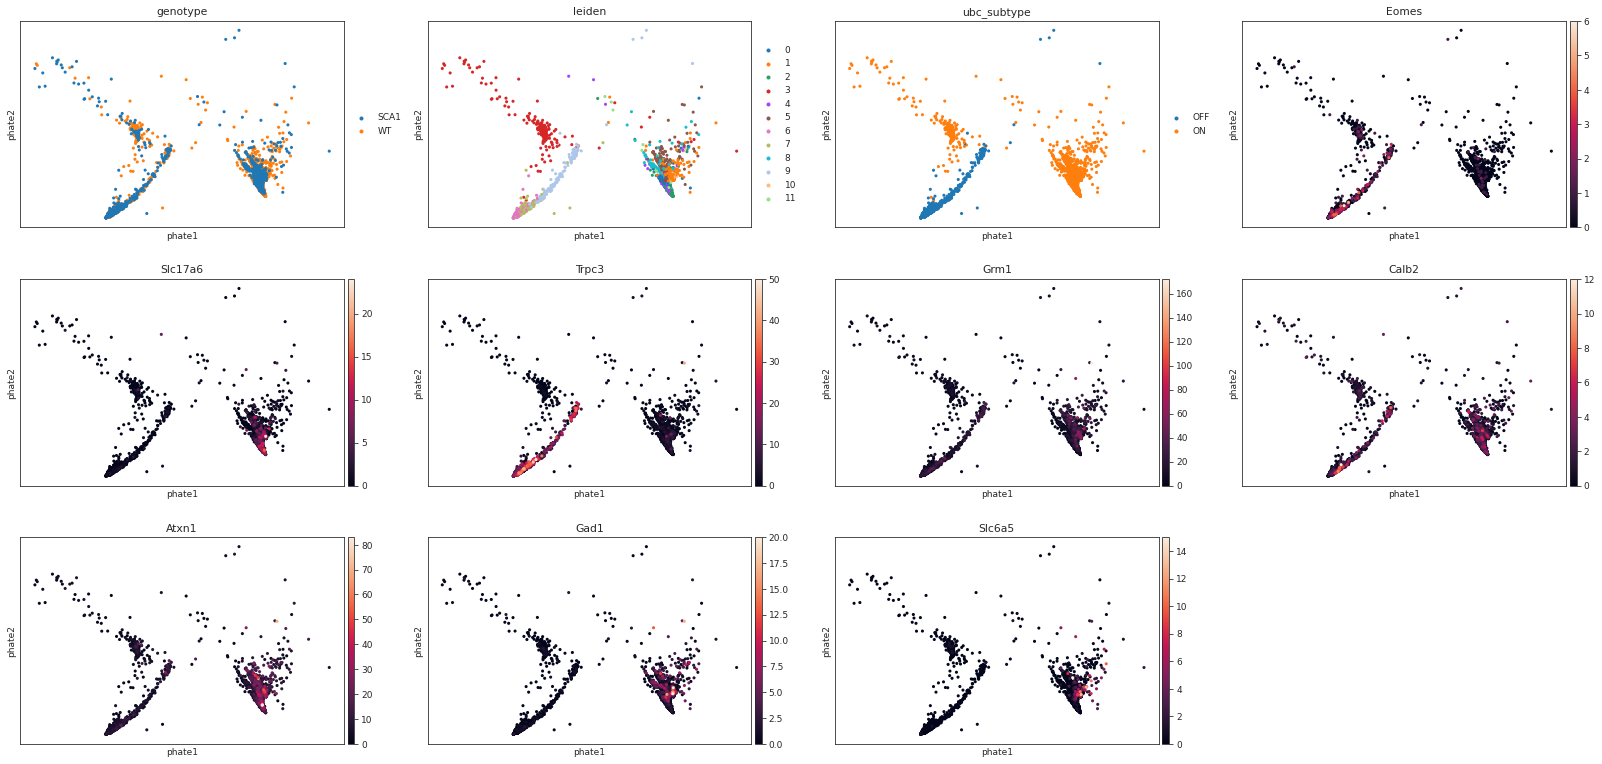

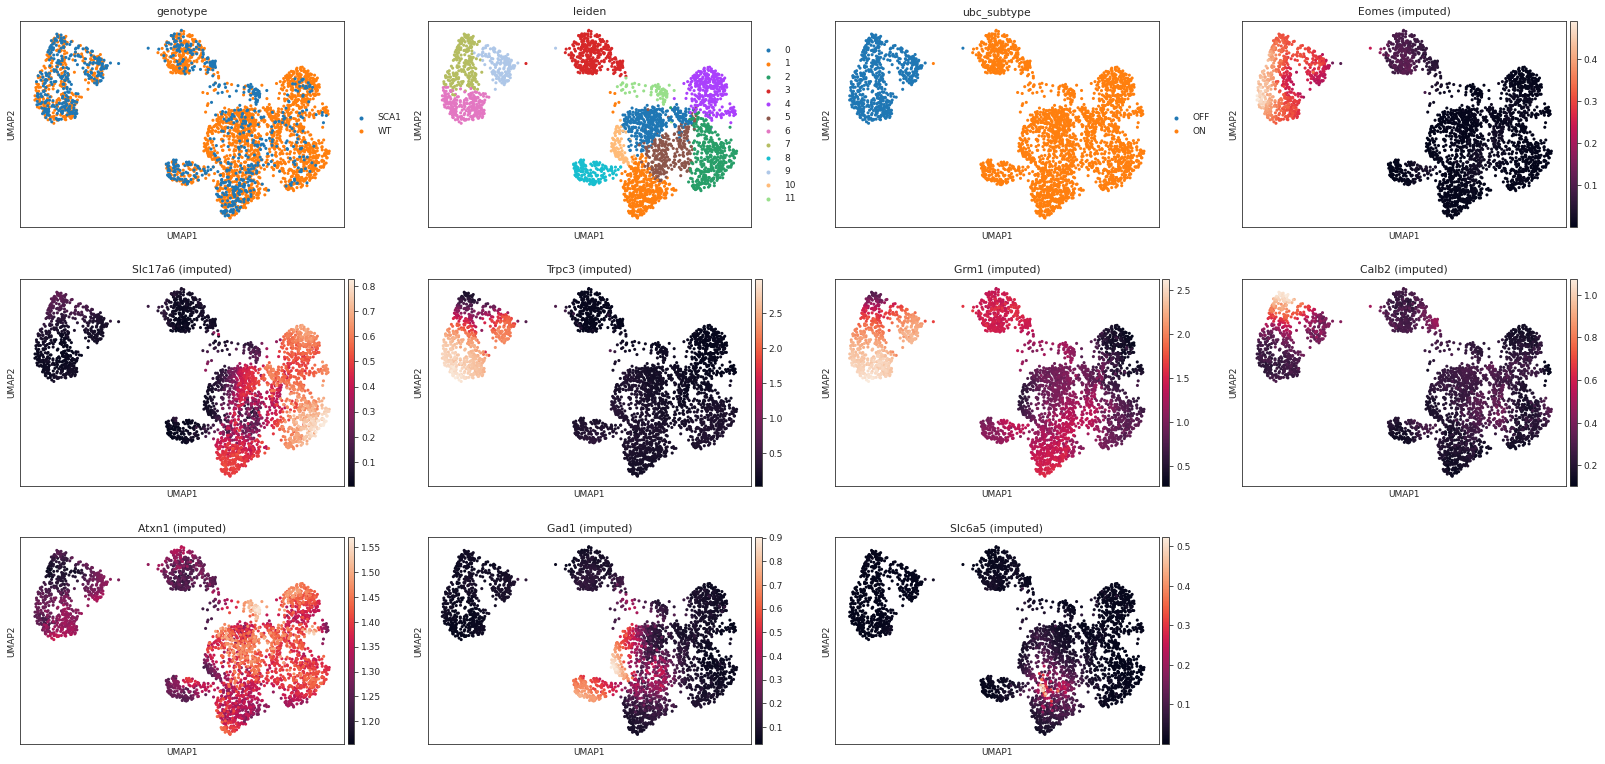

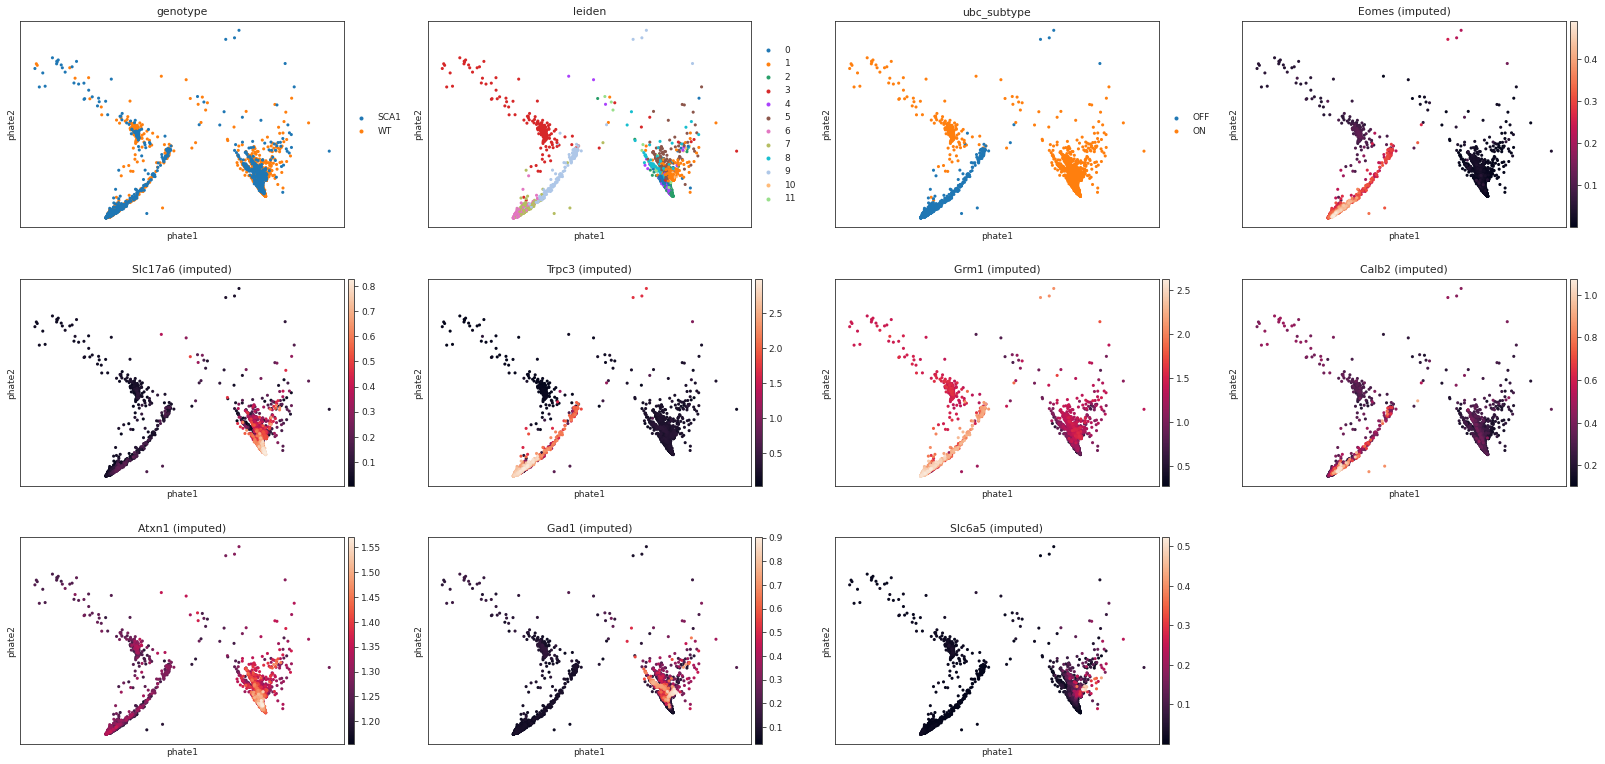

In [10]:
sc.pl.umap(adata, color=['genotype', 'leiden', 'ubc_subtype']+goi, ncols=4, save='_ubcsub.pdf')
sc.external.pl.phate(adata, color=['genotype', 'leiden', 'ubc_subtype']+goi, ncols=4)
sc.pl.umap(adata, color=['genotype', 'leiden', 'ubc_subtype']+['{} (imputed)'.format(i) for i in goi], ncols=4, save='_ubcsub_magict3.pdf')
sc.external.pl.phate(adata,  color=['genotype', 'leiden', 'ubc_subtype']+['{} (imputed)'.format(i) for i in goi], ncols=4)

In [ ]:
# rename ON --> DCN, OFF --> UBC
adata.obs['ubc_subtype'] = adata.obs['ubc_subtype'].astype(str)
adata.obs.loc[adata.obs['ubc_subtype']=='OFF', 'ubc_subtype'] = 'UBC'
adata.obs.loc[adata.obs['ubc_subtype']=='ON', 'ubc_subtype'] = 'DCN'

In [168]:
ubc = adata[adata.obs['ubc_subtype']=='UBC', :]
print(ubc)

View of AnnData object with n_obs × n_vars = 641 × 26374
    obs: 'batch', 'genotype', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'stored_ctype', 'ctype', 'value', 'imp', 'leiden', 'ubc_subtype', 'Eomes (imputed)', 'Slc17a6 (imputed)', 'Trpc3 (imputed)', 'Grm1 (imputed)', 'Calb2 (imputed)', 'Atxn1 (imputed)', 'Gad1 (imputed)', 'Slc6a5 (imputed)'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'genotype_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'ubc_subtype_colors', 'umap'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    varm: 'PCs'
    layers: 'imputed'
    obsp: 'connectivities', 'distances'


Running MAGIC on 641 cells and 8 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...


<ipython-input-4-26056e9cf75c>:7: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  G = gt.Graph(data=X.uns['neighbors']['connectivities']+sparse.diags([1]*X.shape[0],format='csr'),
/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


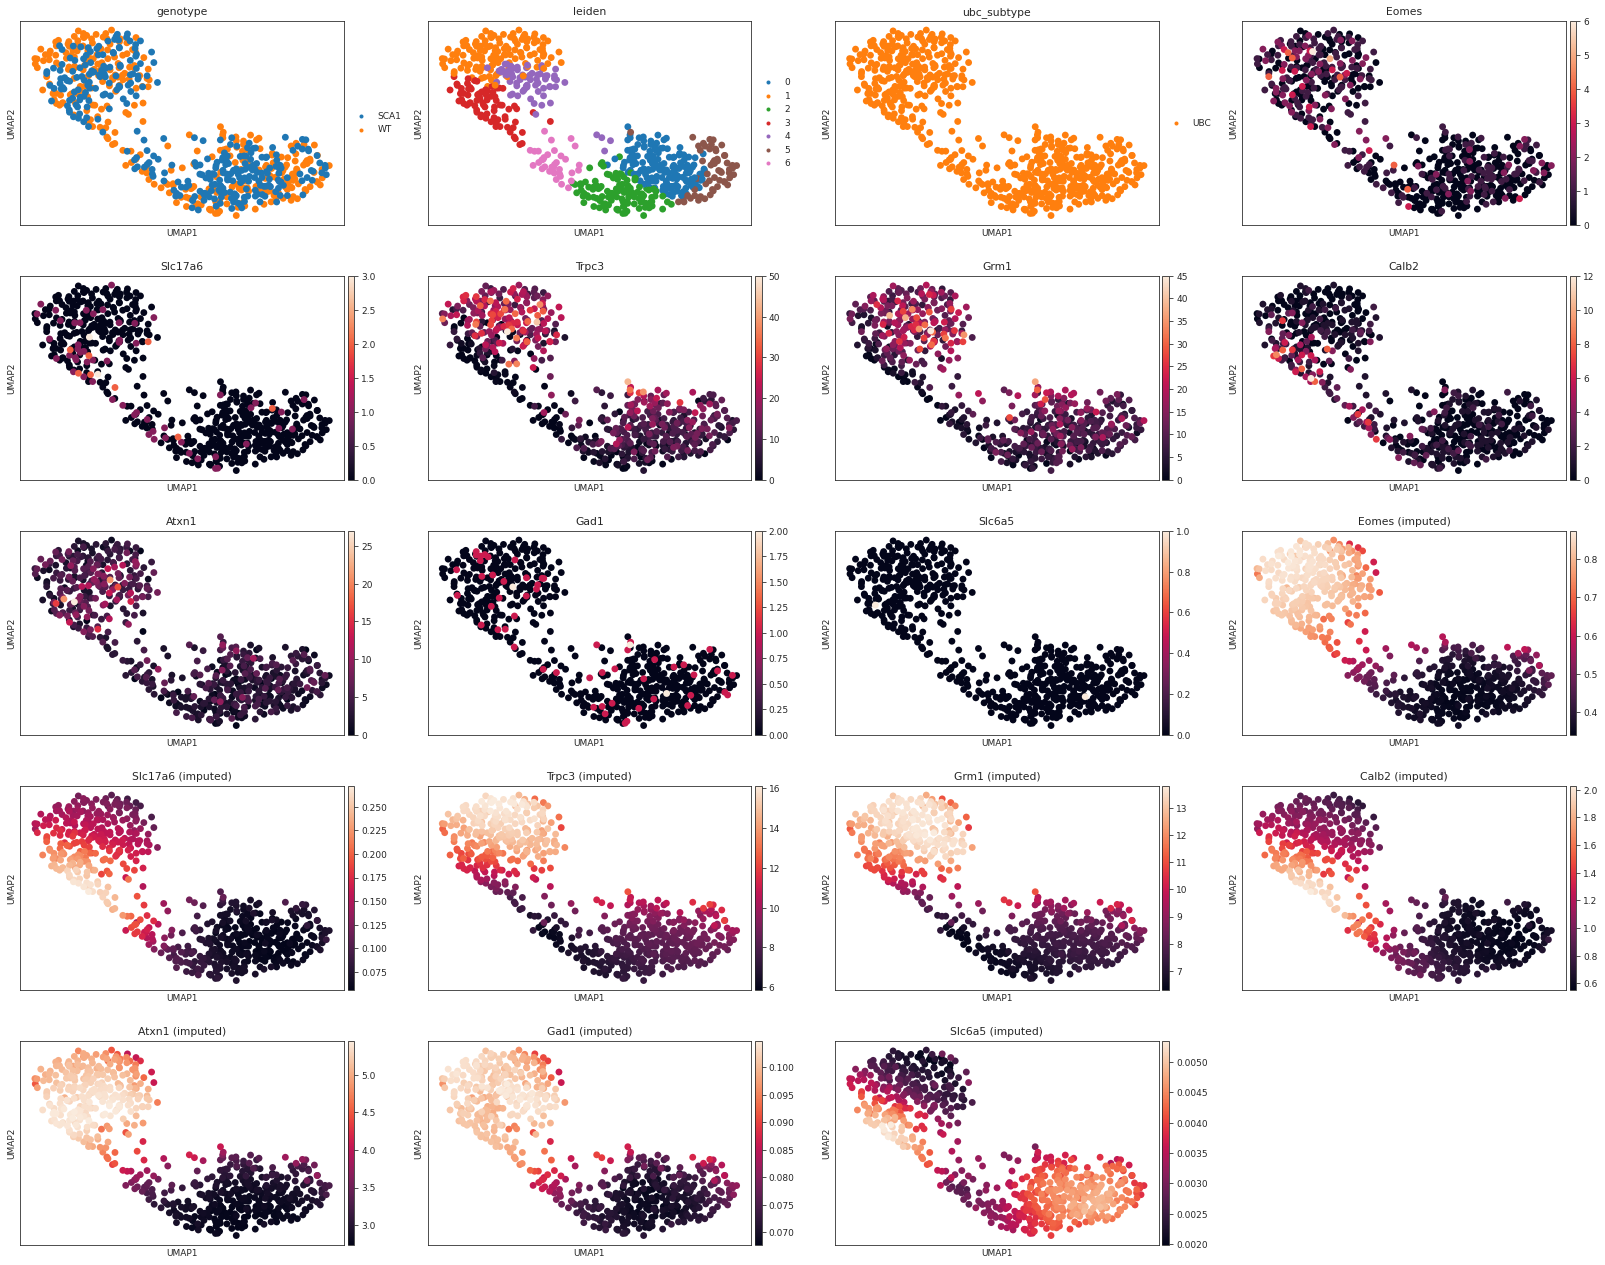

In [197]:
# try old school way
sc.tl.pca(ubc)
# sc.pp.neighbors(ubc, n_pcs=20, n_neighbors=5)
sc.external.pp.bbknn(ubc, neighbors_within_batch=3,# // len(adata.obs['batch'].unique())), 
                     n_pcs=50) # 10 or 50
sc.tl.umap(ubc)#, alpha=0.001, gamma=1.2, min_dist=0.1)
sc.tl.leiden(ubc)

goi = [
    'Eomes',
    'Slc17a6',
    'Trpc3',
    'Grm1',
    'Calb2',
    'Atxn1',
    'Gad1',
    'Slc6a5',
]

Xprime = do_magic(ubc, goi=goi, t=10)
for i in Xprime.columns:
    ubc.obs['{} (imputed)'.format(i)] = Xprime[i].values
    
# plot
sc.pl.umap(ubc, color=['genotype', 'leiden', 'ubc_subtype']+goi+['{} (imputed)'.format(i) for i in goi], ncols=4, save='_ubc_magict10.pdf')

In [202]:
ubc.obs['OFF'] = False
ubc.obs.loc[(ubc.obs['Calb2 (imputed)'] >= ubc.obs['Calb2 (imputed)'].quantile(q=0.7)), 'OFF'] = True

ubc.obs['ON'] = False
ubc.obs.loc[(ubc.obs['Grm1 (imputed)'] >= ubc.obs['Grm1 (imputed)'].quantile(q=0.5)) & ~(ubc.obs['OFF']), 'ON'] = True

In [219]:
ubc.obs['subtype'] = 'None'
ubc.obs.loc[(ubc.obs['Calb2 (imputed)'] >= ubc.obs['Calb2 (imputed)'].quantile(q=0.7)), 'subtype'] = 'OFF'
ubc.obs.loc[(ubc.obs['Grm1 (imputed)'] >= ubc.obs['Grm1 (imputed)'].quantile(q=0.5)) & (ubc.obs['subtype']=='None') , 'subtype'] = 'ON'

... storing 'subtype' as categorical


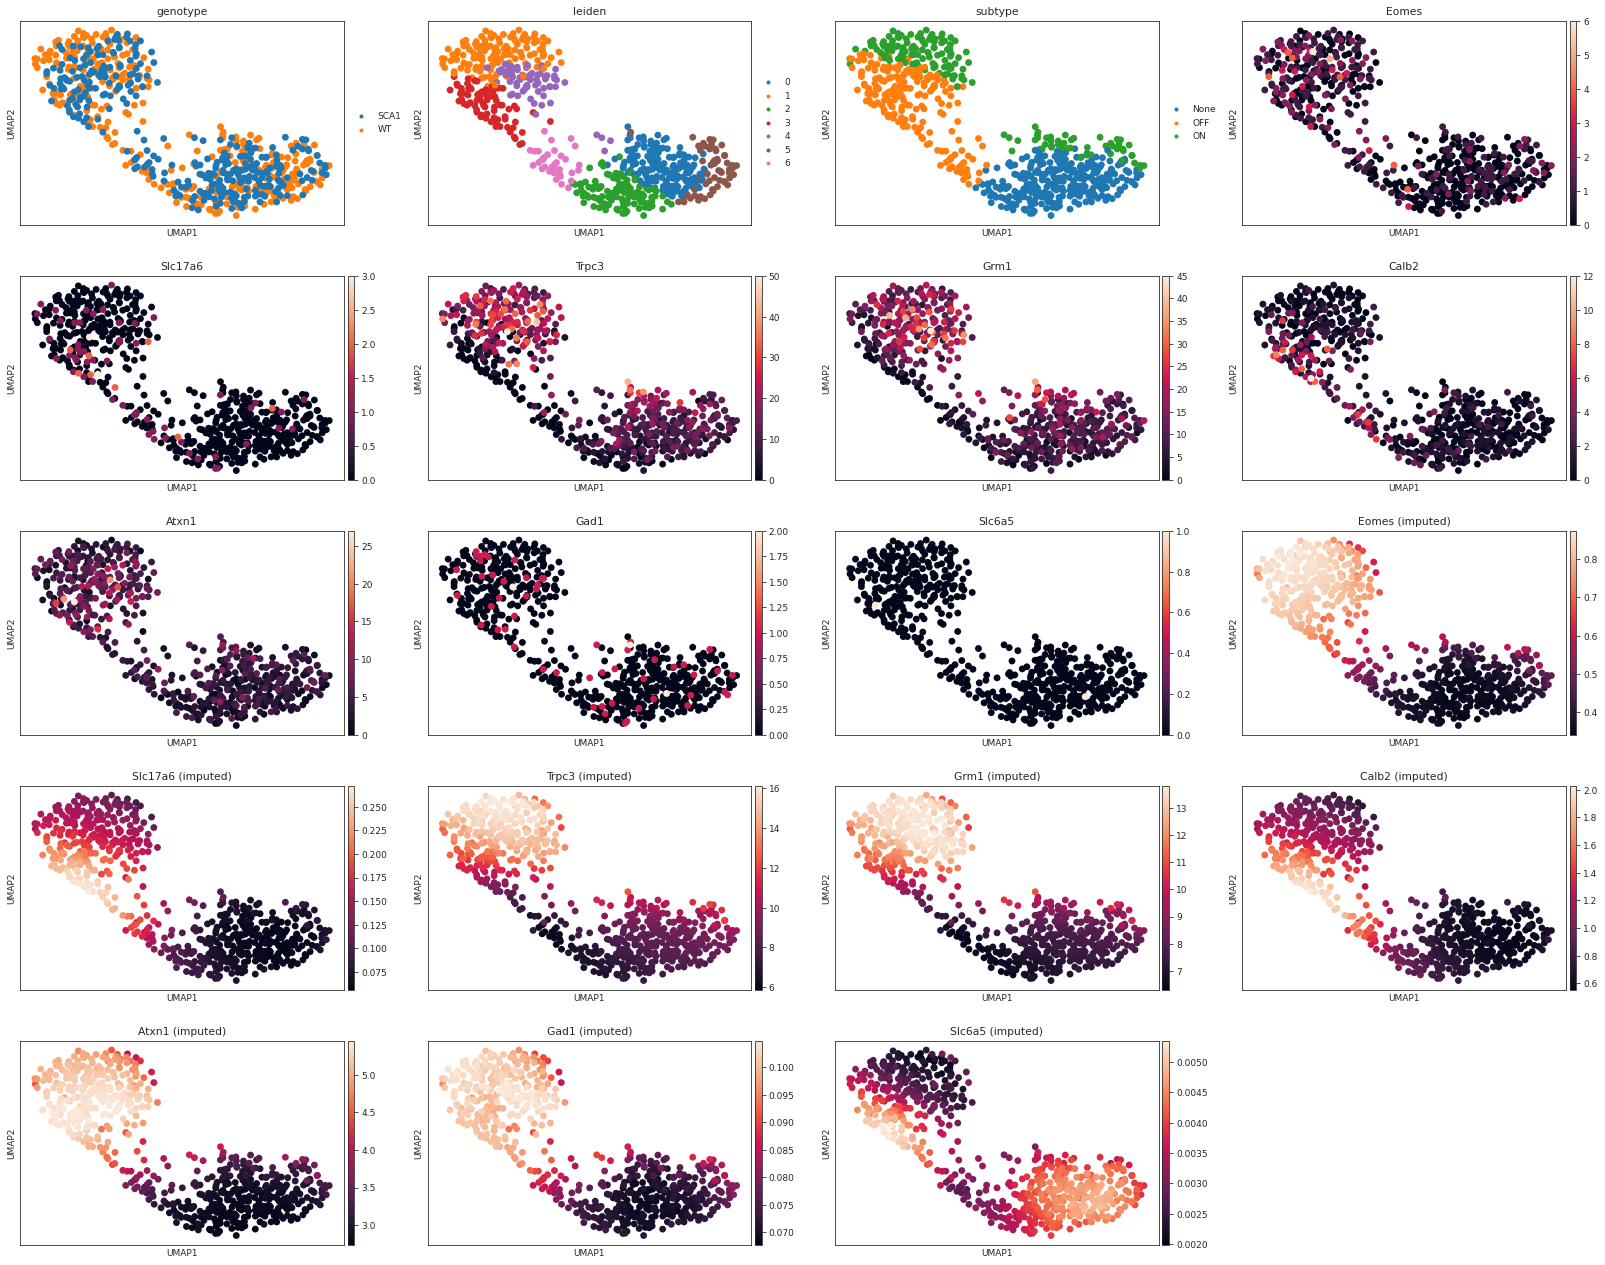

In [220]:
sc.pl.umap(ubc, color=['genotype', 'leiden', 'subtype']+goi+['{} (imputed)'.format(i) for i in goi], ncols=4, save='_ubc_magict10.pdf')

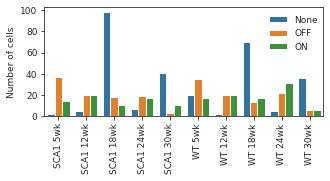

In [221]:
dt = ubc.obs.groupby(['subtype', 'genotype', 'timepoint']).count().reset_index()
dt['genotime'] = dt['genotype'].astype(str) + ' ' + dt['timepoint'].astype(str)
fig, ax = plt.subplots(1, 1, figsize=(5,2))
sns.barplot(x='genotime', y='batch', hue='subtype', 
            data=dt, 
            ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Number of cells')
ax.legend(bbox_to_anchor=(1.01, 1))
fig.savefig('/home/ngr4/project/scnd/results/bar_ubc_subtype_nums.pdf', bbox_inches='tight')

In [222]:
ubc.write('/home/ngr4/project/scnd/data/processed/ubc_210421.h5ad')

# try umaps

In [58]:
ubc_redo = ubc
ubc_redo.X = ubc_redo.raw.X

In [59]:
def do_modifiedrecipe(adata):
    # sc.pp.filter_genes(adata, min_counts=1)         # only consider genes with more than 1 count
    sc.pp.normalize_per_cell(                       # normalize with total UMI count per cell
         adata, key_n_counts='n_counts_all'
    )
    sc.pp.normalize_per_cell(adata)                 # renormalize after filtering
    sc.pp.log1p(adata)                      # log transform: adata.X = log(adata.X + 1)
    sc.pp.scale(adata)   
    return adata

In [60]:
ubc_redo = do_modifiedrecipe(ubc_redo)

Trying to set attribute `.obs` of view, copying.


In [61]:
sc.pp.highly_variable_genes(ubc_redo)

In [62]:
sc.tl.pca(ubc_redo, use_highly_variable=True)
sc.pp.neighbors(ubc_redo, n_pcs=10, n_neighbors=30)
# sc.external.pp.bbknn(adata, neighbors_within_batch=(30 // len(adata.obs['batch'].unique())), n_pcs=50)
sc.tl.umap(ubc_redo)
sc.tl.leiden(ubc_redo)

In [63]:
goi = [
    'Eomes',
    'Slc17a6',
    'Trpc3',
    'Grm1',
    'Calb2',
    'Atxn1',
    'Gad1',
    'Slc6a5',
]

Xprime = do_magic(ubc_redo, goi=goi, t=10)
for i in Xprime.columns:
    ubc_redo.obs['{} (imputed)'.format(i)] = Xprime[i].values

Running MAGIC on 641 cells and 8 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...


<ipython-input-4-26056e9cf75c>:7: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  G = gt.Graph(data=X.uns['neighbors']['connectivities']+sparse.diags([1]*X.shape[0],format='csr'),
/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


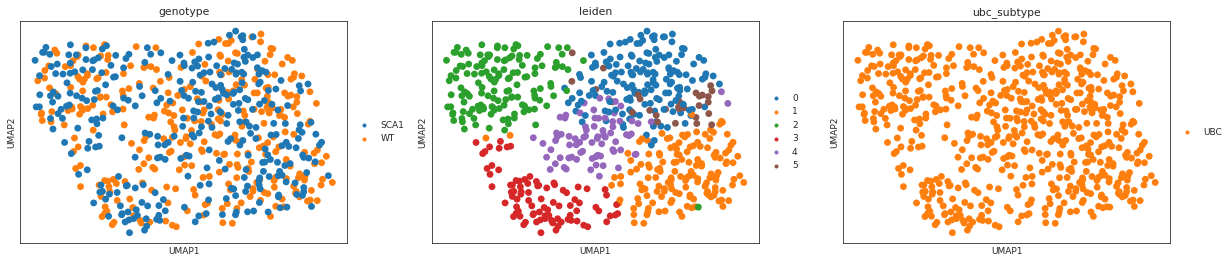

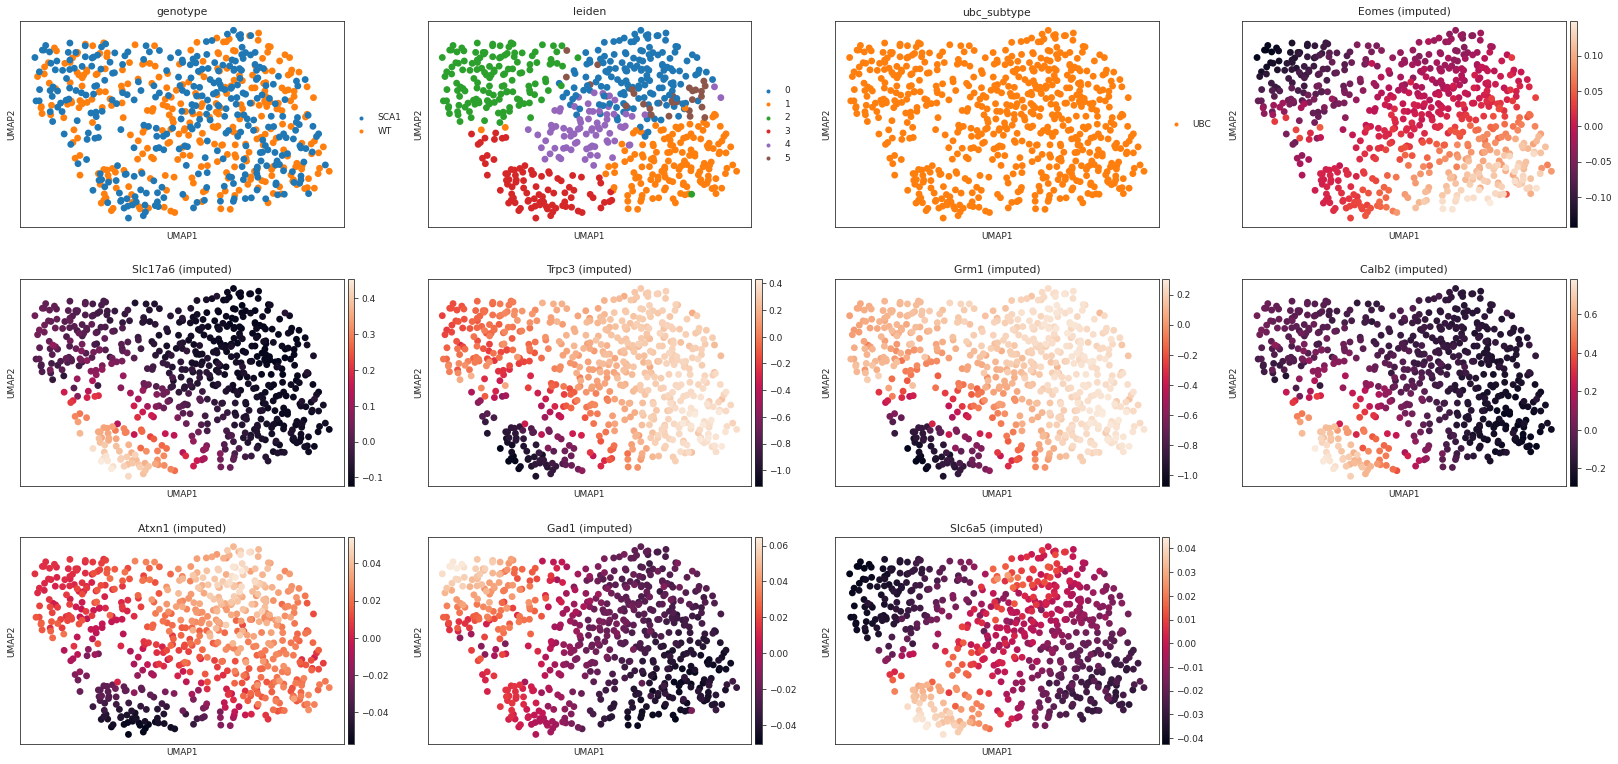

In [65]:
sc.pl.umap(ubc_redo, color=['genotype', 'leiden', 'ubc_subtype'], ncols=4)
sc.pl.umap(ubc_redo, color=['genotype', 'leiden', 'ubc_subtype']+['{} (imputed)'.format(i) for i in goi], ncols=4)


Signature:
sc.tl.pca(
    data: Union[anndata._core.anndata.AnnData, numpy.ndarray, scipy.sparse.base.spmatrix],
    n_comps: Union[int, NoneType] = None,
    zero_center: Union[bool, NoneType] = True,
    svd_solver: str = 'arpack',
    random_state: Union[NoneType, int, numpy.random.mtrand.RandomState] = 0,
    return_info: bool = False,
    use_highly_variable: Union[bool, NoneType] = None,
    dtype: str = 'float32',
    copy: bool = False,
    chunked: bool = False,
    chunk_size: Union[int, NoneType] = None,
) -> Union[anndata._core.anndata.AnnData, numpy.ndarray, scipy.sparse.base.spmatrix]
Docstring:
Principal component analysis [Pedregosa11]_.

Computes PCA coordinates, loadings and variance decomposition.
Uses the implementation of *scikit-learn* [Pedregosa11]_.

.. versionchanged:: 1.5.0

    In previous versions, computing a PCA on a sparse matrix would make a dense copy of
    the array for mean centering.
    As of scanpy 1.5.0, mean centering is implicit.
    While resu

In [164]:
# try old school way
sc.tl.pca(ubc)
sc.pp.neighbors(ubc, n_pcs=20, n_neighbors=5)
# sc.external.pp.bbknn(ubc, neighbors_within_batch=3,# // len(adata.obs['batch'].unique())), 
#                      n_pcs=20) # 10 or 50
sc.tl.umap(ubc)#, alpha=0.001, gamma=1.2, min_dist=0.1)
sc.tl.leiden(ubc)

In [165]:
goi = [
    'Eomes',
    'Slc17a6',
    'Trpc3',
    'Grm1',
    'Calb2',
    'Atxn1',
    'Gad1',
    'Slc6a5',
]

Xprime = do_magic(ubc, goi=goi, t=10)
for i in Xprime.columns:
    ubc.obs['{} (imputed)'.format(i)] = Xprime[i].values

Running MAGIC on 641 cells and 8 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...


<ipython-input-4-26056e9cf75c>:7: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  G = gt.Graph(data=X.uns['neighbors']['connectivities']+sparse.diags([1]*X.shape[0],format='csr'),
/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


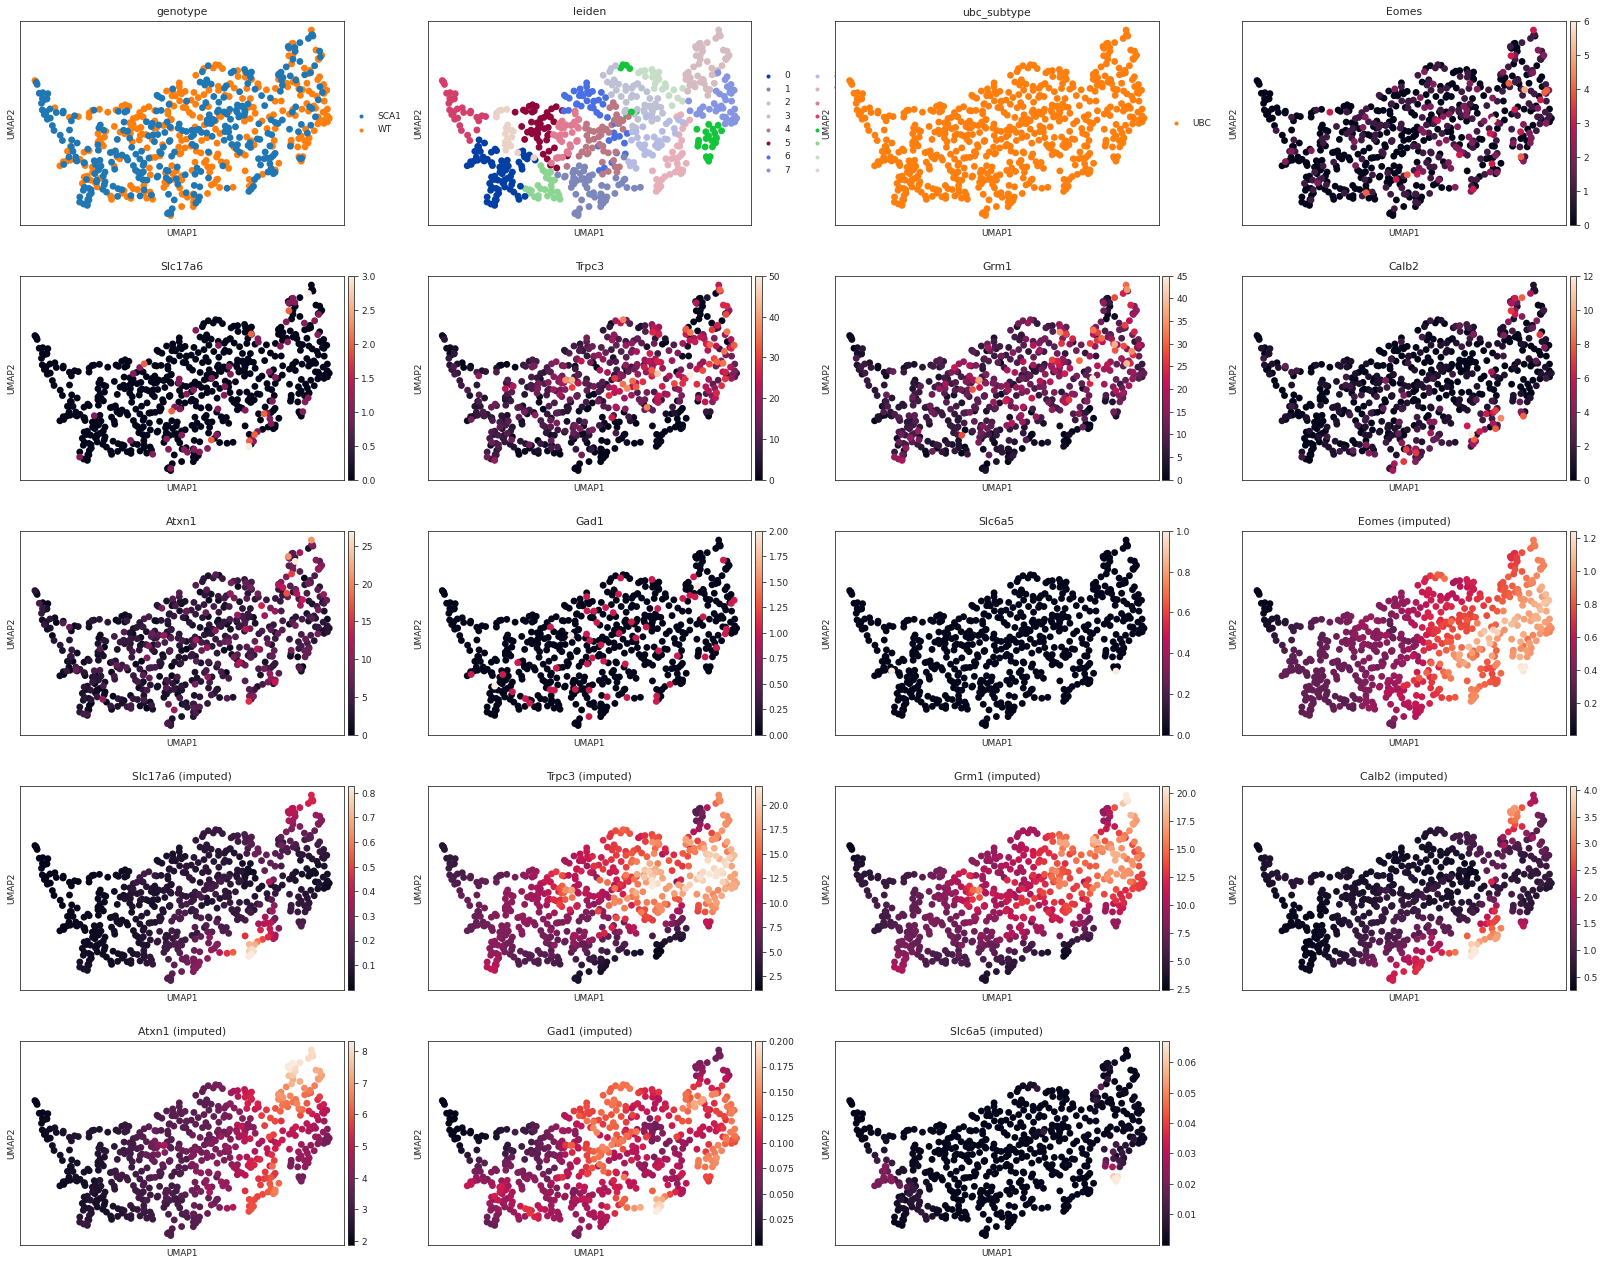

In [166]:
sc.pl.umap(ubc, color=['genotype', 'leiden', 'ubc_subtype']+goi+['{} (imputed)'.format(i) for i in goi], ncols=4, save='_ubc_magict10.pdf')

In [160]:
ubc.obs['OFF'] = False
ubc.obs.loc[(ubc.obs['Calb2 (imputed)'] >= ubc.obs['Calb2 (imputed)'].quantile(q=0.7)), 'OFF'] = True

ubc.obs['ON'] = False
ubc.obs.loc[(ubc.obs['Grm1 (imputed)'] >= ubc.obs['Grm1 (imputed)'].quantile(q=0.5)), 'ON'] = True

In [161]:
ubc.obs.loc[(ubc.obs['ON']) & ubc.obs['OFF'], :]

batch genotype timepoint  n_genes_by_counts  \
ATCCTATCAGGCCTGT-1-7202-WTimp      7202       WT       5wk               4702   
CGCATGGCAGGAGACT-1-7202-WTimp      7202       WT       5wk               3760   
GACCCAGCAGGAACCA-1-7202-WTimp      7202       WT       5wk               2878   
GCAGCTGCATCACCAA-1-7202-WTimp      7202       WT       5wk               3195   
GGTAGAGCATTAGGAA-1-7202-WTimp      7202       WT       5wk               3612   
...                                 ...      ...       ...                ...   
CGATGGCCACACGCCA-1-20212-SCA1imp  20212     SCA1      24wk               5068   
GGGCTCATCTTTACAC-1-20212-SCA1imp  20212     SCA1      24wk               4603   
TAGTGCATCCATAGGT-1-20212-SCA1imp  20212     SCA1      24wk               3427   
TCACAAGCACAAGTGG-1-20212-SCA1imp  20212     SCA1      24wk               3683   
TCATACTGTAACGGTG-1-20212-SCA1imp  20212     SCA1      24wk               4667   

                                  log1p_n_genes_by_counts  total_counts  \
ATCCTATCAGGCCTGT-1-7202-WTimp                    8.455956       14073.0   
CGCATGGCAGGAGACT-1-7202-WTimp                    8.232440        9343.0   
GACCCAGCAGGAACCA-1-7202-WTimp                    7.965198        6502.0   
GCAGCTGCATCACCAA-1-7202-WTimp                    8.069655        7883.0   
GGTAGAGCATTAGGAA-1-7202-WTimp                    8.192294        9010.0   
...                                                   ...           ...   
CGATGGCCACACGCCA-1-20212-SCA1imp                 8.530899       17884.0   
GGGCTCATCTTTACAC-1-20212-SCA1imp                 8.434681       15560.0   
TAGTGCATCCATAGGT-1-20212-SCA1imp                 8.139732        8357.0   
TCACAAGCACAAGTGG-1-20212-SCA1imp                 8.211754        9200.0   
TCATACTGTAACGGTG-1-20212-SCA1imp                 8.448486       15872.0   

                                  log1p_total_counts  \
ATCCTATCAGGCCTGT-1-7202-WTimp               9.552084   
CGCATGGCAGGAGACT-1-7202-WTimp               9.142489   
GACCCAGCAGGAACCA-1-7202-WTimp               8.780019   
GCAGCTGCATCACCAA-1-7202-WTimp               8.972590   
GGTAGAGCATTAGGAA-1-7202-WTimp               9.106201   
...                                              ...   
CGATGGCCACACGCCA-1-20212-SCA1imp            9.791718   
GGGCTCATCTTTACAC-1-20212-SCA1imp            9.652523   
TAGTGCATCCATAGGT-1-20212-SCA1imp            9.030974   
TCACAAGCACAAGTGG-1-20212-SCA1imp            9.127068   
TCATACTGTAACGGTG-1-20212-SCA1imp            9.672375   

                                  pct_counts_in_top_50_genes  \
ATCCTATCAGGCCTGT-1-7202-WTimp                      21.956939   
CGCATGGCAGGAGACT-1-7202-WTimp                      20.817724   
GACCCAGCAGGAACCA-1-7202-WTimp                      23.869579   
GCAGCTGCATCACCAA-1-7202-WTimp                      23.988329   
GGTAGAGCATTAGGAA-1-7202-WTimp                      22.119867   
...                                                      ...   
CGATGGCCACACGCCA-1-20212-SCA1imp                   23.937598   
GGGCTCATCTTTACAC-1-20212-SCA1imp                   27.937018   
TAGTGCATCCATAGGT-1-20212-SCA1imp                   23.345698   
TCACAAGCACAAGTGG-1-20212-SCA1imp                   22.456522   
TCATACTGTAACGGTG-1-20212-SCA1imp                   24.691280   

                                  pct_counts_in_top_100_genes  \
ATCCTATCAGGCCTGT-1-7202-WTimp                       27.911604   
CGCATGGCAGGAGACT-1-7202-WTimp                       27.550037   
GACCCAGCAGGAACCA-1-7202-WTimp                       30.744386   
GCAGCTGCATCACCAA-1-7202-WTimp                       31.028796   
GGTAGAGCATTAGGAA-1-7202-WTimp                       28.834628   
...                                                       ...   
CGATGGCCACACGCCA-1-20212-SCA1imp                    30.759338   
GGGCTCATCTTTACAC-1-20212-SCA1imp                    34.717224   
TAGTGCATCCATAGGT-1-20212-SCA1imp                    30.190260   
TCACAAGCACAAGTGG-1-20212-SCA1imp                    29.173913   
TCA

In [162]:
ubc.obs.loc[(ubc.obs['ON']), :]

batch genotype timepoint  n_genes_by_counts  \
AAATGGAAGCTTACGT-1-7202-WTimp      7202       WT       5wk               2147   
ATCCTATCAGGCCTGT-1-7202-WTimp      7202       WT       5wk               4702   
CAACGATTCGCACGGT-1-7202-WTimp      7202       WT       5wk               3036   
CGCATGGCAGGAGACT-1-7202-WTimp      7202       WT       5wk               3760   
CTGTACCGTGATAGAT-1-7202-WTimp      7202       WT       5wk               2850   
...                                 ...      ...       ...                ...   
TGACTCCGTAGCACGA-1-58241-SCA1imp  58241     SCA1      30wk               3282   
ACCAAACCAGAACATA-1-58242-SCA1imp  58242     SCA1      30wk               3150   
CTGCCTAGTGAATATG-1-58242-SCA1imp  58242     SCA1      30wk               3178   
GACCCAGTCCACGTAA-1-58242-SCA1imp  58242     SCA1      30wk               2829   
TTCTTGACACGCCAGT-1-58242-SCA1imp  58242     SCA1      30wk               3436   

                                  log1p_n_genes_by_counts  total_counts  \
AAATGGAAGCTTACGT-1-7202-WTimp                    7.672292        4131.0   
ATCCTATCAGGCCTGT-1-7202-WTimp                    8.455956       14073.0   
CAACGATTCGCACGGT-1-7202-WTimp                    8.018625        8110.0   
CGCATGGCAGGAGACT-1-7202-WTimp                    8.232440        9343.0   
CTGTACCGTGATAGAT-1-7202-WTimp                    7.955425        6081.0   
...                                                   ...           ...   
TGACTCCGTAGCACGA-1-58241-SCA1imp                 8.096513        7755.0   
ACCAAACCAGAACATA-1-58242-SCA1imp                 8.055475        7098.0   
CTGCCTAGTGAATATG-1-58242-SCA1imp                 8.064322        7043.0   
GACCCAGTCCACGTAA-1-58242-SCA1imp                 7.948032        6343.0   
TTCTTGACACGCCAGT-1-58242-SCA1imp                 8.142354        8375.0   

                                  log1p_total_counts  \
AAATGGAAGCTTACGT-1-7202-WTimp               8.326517   
ATCCTATCAGGCCTGT-1-7202-WTimp               9.552084   
CAACGATTCGCACGGT-1-7202-WTimp               9.000977   
CGCATGGCAGGAGACT-1-7202-WTimp               9.142489   
CTGTACCGTGATAGAT-1-7202-WTimp               8.713089   
...                                              ...   
TGACTCCGTAGCACGA-1-58241-SCA1imp            8.956222   
ACCAAACCAGAACATA-1-58242-SCA1imp            8.867709   
CTGCCTAGTGAATATG-1-58242-SCA1imp            8.859932   
GACCCAGTCCACGTAA-1-58242-SCA1imp            8.755265   
TTCTTGACACGCCAGT-1-58242-SCA1imp            9.033126   

                                  pct_counts_in_top_50_genes  \
AAATGGAAGCTTACGT-1-7202-WTimp                      22.512709   
ATCCTATCAGGCCTGT-1-7202-WTimp                      21.956939   
CAACGATTCGCACGGT-1-7202-WTimp                      23.970407   
CGCATGGCAGGAGACT-1-7202-WTimp                      20.817724   
CTGTACCGTGATAGAT-1-7202-WTimp                      22.594968   
...                                                      ...   
TGACTCCGTAGCACGA-1-58241-SCA1imp                   20.735010   
ACCAAACCAGAACATA-1-58242-SCA1imp                   20.583263   
CTGCCTAGTGAATATG-1-58242-SCA1imp                   19.963084   
GACCCAGTCCACGTAA-1-58242-SCA1imp                   20.936465   
TTCTTGACACGCCAGT-1-58242-SCA1imp                   20.811940   

                                  pct_counts_in_top_100_genes  \
AAATGGAAGCTTACGT-1-7202-WTimp                       29.678044   
ATCCTATCAGGCCTGT-1-7202-WTimp                       27.911604   
CAACGATTCGCACGGT-1-7202-WTimp                       32.540074   
CGCATGGCAGGAGACT-1-7202-WTimp                       27.550037   
CTGTACCGTGATAGAT-1-7202-WTimp                       28.811051   
...                                                       ...   
TGACTCCGTAGCACGA-1-58241-SCA1imp                    27.582205   
ACCAAACCAGAACATA-1-58242-SCA1imp                    27.373908   
CTGCCTAGTGAATATG-1-58242-SCA1imp                    26.579583   
GACCCAGTCCACGTAA-1-58242-SCA1imp                    28.708813   
TTC

In [180]:
ubc = adata[adata.obs['ubc_subtype']=='UBC', :]
ubc_redo = ubc
ubc_redo.X = ubc_redo.raw.X

# try old school way
sc.tl.pca(ubc_redo)
sc.pp.neighbors(ubc_redo, n_pcs=20, n_neighbors=5)
# sc.external.pp.bbknn(ubc_redo, neighbors_within_batch=3,# // len(adata.obs['batch'].unique())), 
#                      n_pcs=50) # 10 or 50
sc.tl.umap(ubc_redo)#, alpha=0.001, gamma=1.2, min_dist=0.1)
sc.tl.leiden(ubc_redo)

In [181]:
ubc.obsm['X_umap'] = ubc_redo.obsm['X_umap']

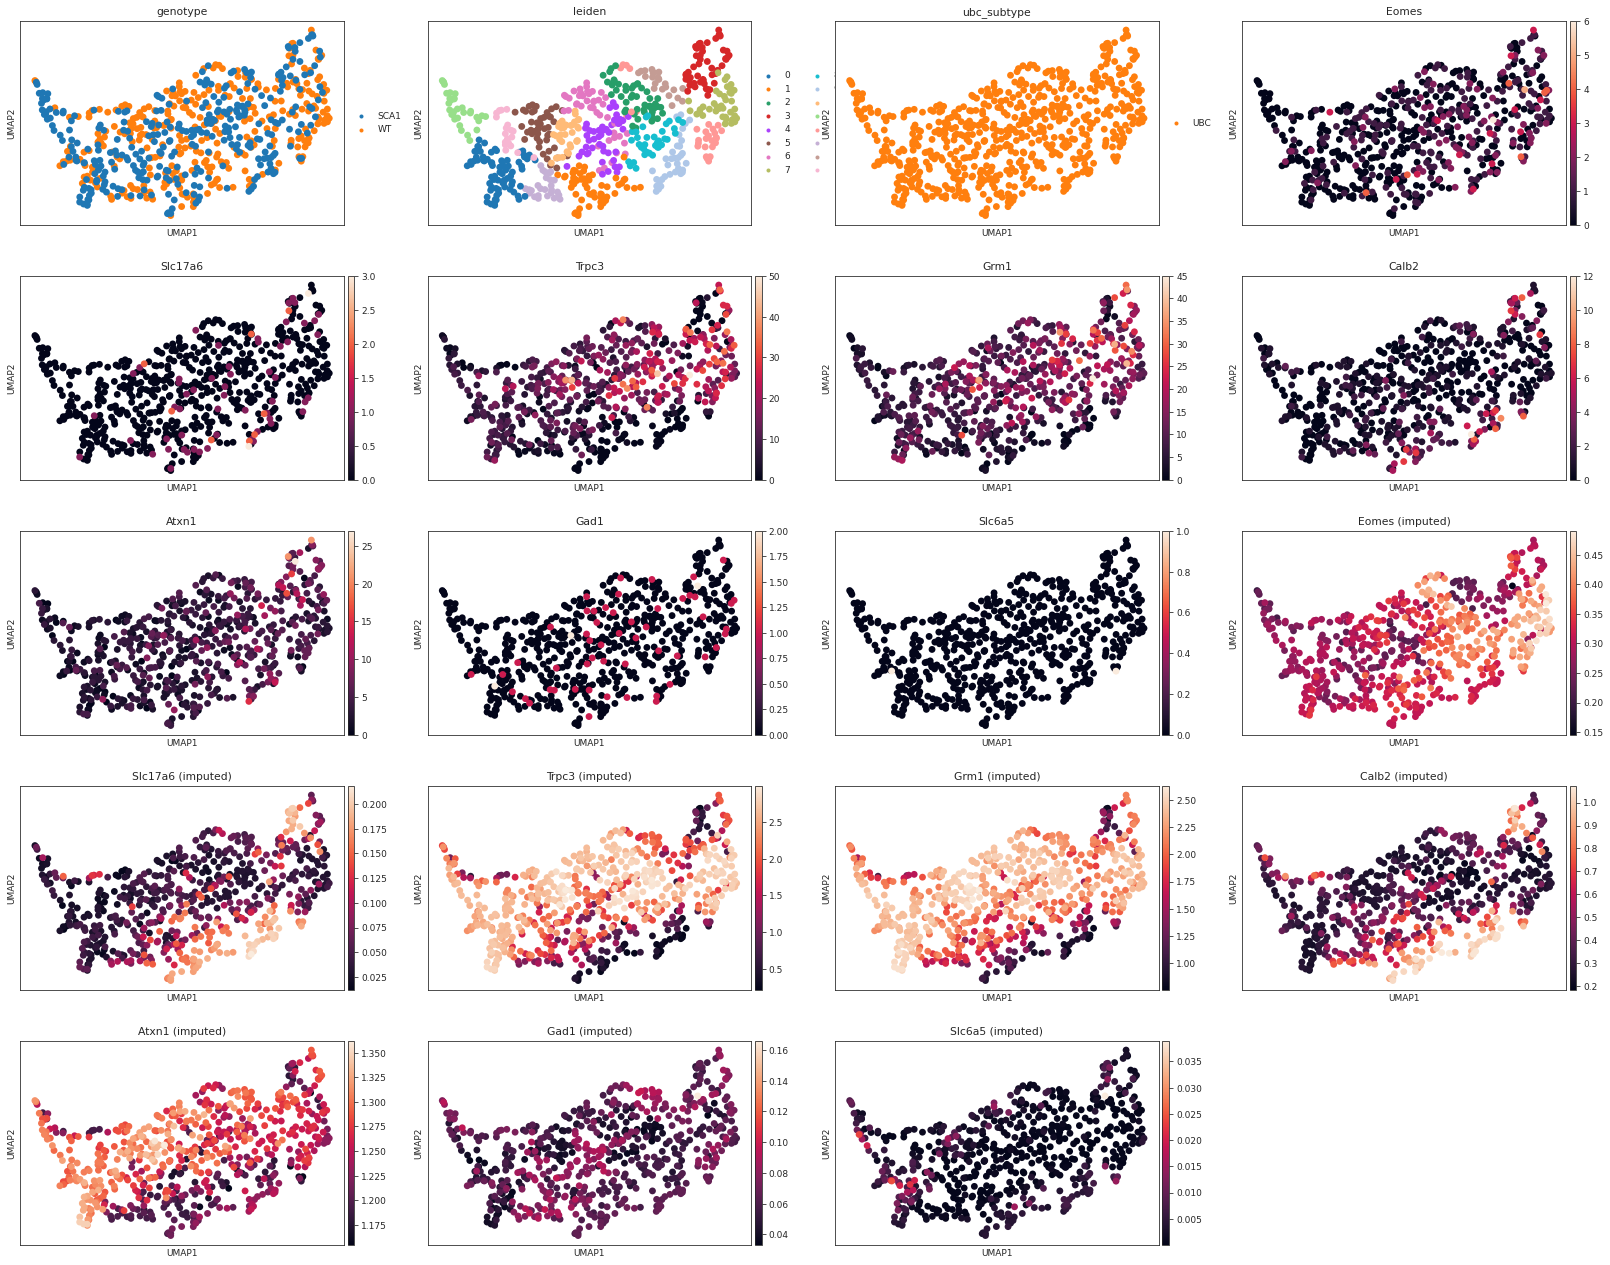

In [182]:
sc.pl.umap(ubc, color=['genotype', 'leiden', 'ubc_subtype']+goi+['{} (imputed)'.format(i) for i in goi], ncols=4, save='_ubc_magict10.pdf')

In [187]:
ubc = adata[adata.obs['ubc_subtype']=='UBC', :]
print(ubc)

View of AnnData object with n_obs × n_vars = 641 × 26374
    obs: 'batch', 'genotype', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'stored_ctype', 'ctype', 'value', 'imp', 'leiden', 'ubc_subtype', 'Eomes (imputed)', 'Slc17a6 (imputed)', 'Trpc3 (imputed)', 'Grm1 (imputed)', 'Calb2 (imputed)', 'Atxn1 (imputed)', 'Gad1 (imputed)', 'Slc6a5 (imputed)'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'genotype_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'ubc_subtype_colors', 'umap'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    varm: 'PCs'
    layers: 'imputed'
    obsp: 'connectivities', 'distances'


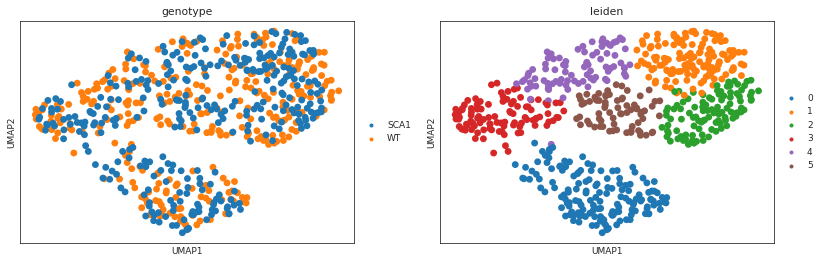

In [190]:
sc.tl.pca(ubc)
# sc.external.pp.bbknn(ubc, neighbors_within_batch=(100 // len(ubc.obs['batch'].unique())), n_pcs=50)
sc.tl.umap(ubc, min_dist=0.4)
sc.tl.leiden(ubc)
sc.pl.umap(ubc, color=['genotype', 'leiden'])